In [2]:
from utils import *
import numpy.linalg as LA

img_src = '.'

# SIFT Detection and Descriptors

L'algoritmo SIFT si basa essenzialmente su 4 concetti: 
- Scale-space extrema detection
- Keypoint localization
- Orientation assignment
- Local descriptor creation


Proviamo ad illustrare i vari concetti sulla solita immagine

Shape (415, 572)


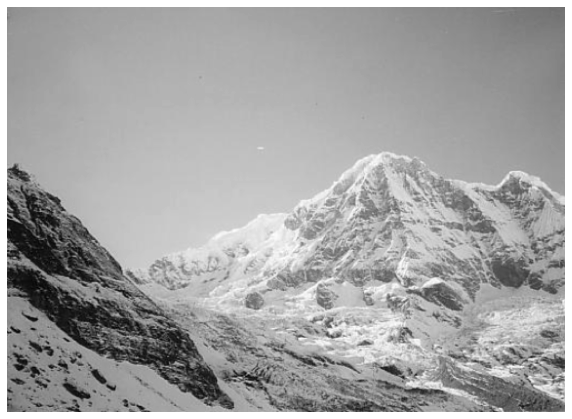

In [3]:
imageFull = mp_image.imread(os.path.join(img_src,'mountain_view1.png'))

image = rgb2gray(imageFull)

maxv, minv = np.max(image), np.min(image)

image = (image - minv)/(maxv-minv)

print('Shape', image.shape)
img_show(image,cmap=cm.gray)

## Scale-space

Cominciamo con l'illustrare la piramide gaussiana. 

Il concetto di scale-space può essere illustrato applicando il filtro gaussiano ad un'immagine per valori differenti di deviazione standard. 

Dalle proprietà della distribuzione gaussiana sappiamo che $6\sigma$ rappresenta il range che racchiude il 99% dei dati distribuiti secondo una gaussiana. Questo significa che, se immaginiamo una griglia di punti, tutti i punti che distano più di $3\sigma$ dal centro avranno valore 0.Un valore di $\sigma$ esprime quindi un filtro gaussiano di dimensione $s = 2\cdot \lceil 3\sigma\rceil +1$. 

Proviamo ora ad applicare alla stessa immagine un filtro gaussiano corrispondente a valori crescenti di devianza, su un fattore $2^k$ rispetto ad un valore iniziale di $\sigma$. 


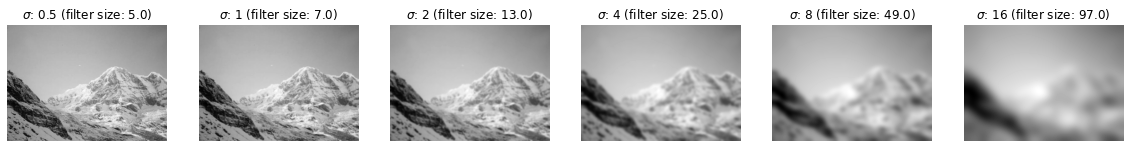

In [4]:
fig = plt.figure(figsize=(20, 20))

num_octave = 6

for i in range(num_octave):
    sigma = 2**(i-1)
    fig.add_subplot(1, num_octave, i+1) 
    plt.imshow(ndimage.gaussian_filter(image,sigma),cmap=cm.gray)
    s = 2*np.ceil(3*sigma)+1
    plt.title(f'$\sigma$: {sigma} (filter size: {s})')
    plt.axis('off')

plt.show()

Di fatto, l'applicazione del filtro simula la perdita di dettagli che occorrerebbe se la scala dell'immagine decrescesse progressivamente. Infatti, poiché il filtro gaussiano fa smoothing dell'intensità, non c'è bisogno di tenere tutti i pixel e di fatto possiamo eliminarli. Proviamo a plottare le varie figure dimezzando la dimensione ad ogni passaggio

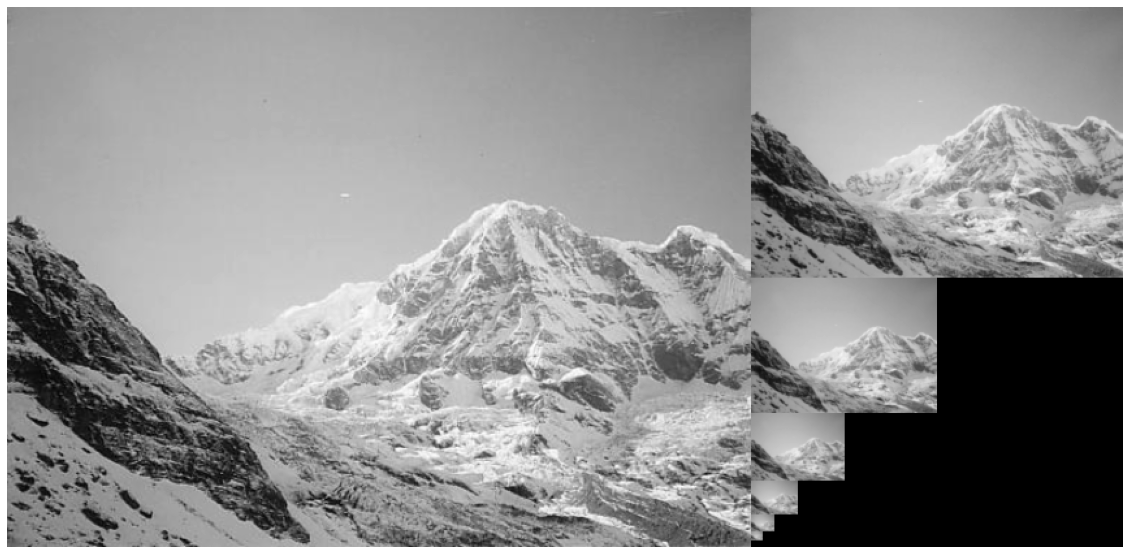

In [5]:
rows,cols = image.shape

output = np.zeros((rows,cols+cols//2))

output[:rows,:cols] = image

num_octave = 6

cur_scale = image

horiz = True
rows = 0

for i in range(num_octave):
    sigma = 2**i
    cur_scale = ndimage.gaussian_filter(image,sigma)
    cur_scale = cur_scale[::2**(i+1),::2**(i+1)]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
    rows += rows_scaled
        
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap=cm.gray)
plt.axis('off')
plt.show()

Nella figura sopra, l'immagine grande è l'originale, mentre a destra troviamo le riduzioni. Si noti come, nelle riduzioni, si perdono progressivamente i dettagli mentre il focus sulle componenti principali dell'immagine rimane. 
Proviamo a fare le stesse operazioni in sequenza. 

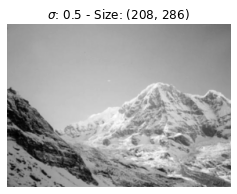

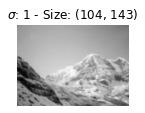

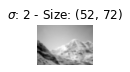

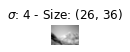

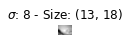

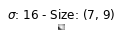

In [6]:
sz = 4

num_octave = 6

cur_scale = np.copy(image)
sigma = 1

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    
    plt.figure(figsize=(sz, sz))
    plt.imshow(cur_scale,cmap=cm.gray)
    s = 2*np.ceil(3*2**(i-1))+1
    plt.title(f'$\sigma$: {2**(i-1)} - Size: {cur_scale.shape}')
    plt.axis('off')
    plt.show()
    
    sz = sz/2
    


La sequenza che abbiamo costruito è una piramide Gaussiana. Nella rappresentazione compatta: 

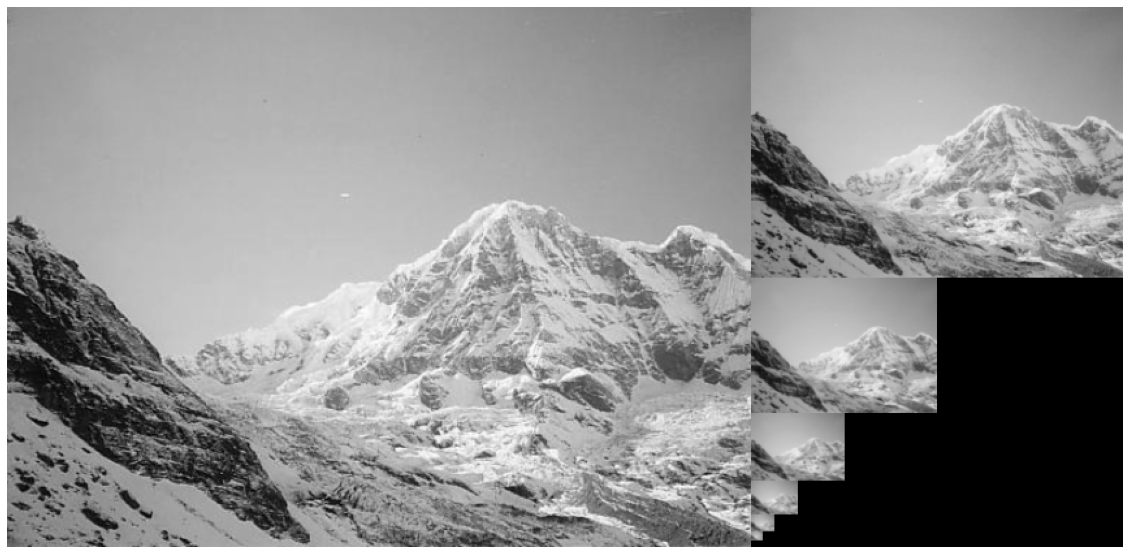

In [7]:
rows,cols = image.shape

output = np.zeros((rows,cols+cols//2))

output[:rows,:cols] = image

num_octave = 6
sigma = 1

cur_scale = image

horiz = True
rows = 0

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
    rows += rows_scaled
        
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap=cm.gray)
plt.axis('off')
plt.show()

Riuscite a scorgere la differenza tra questa immagine e l'immagine di sopra?


Lo Scale space rappresenta un'immagine come una famiglia di versioni smoothed della stessa immagine, con l'obiettivo di simulare la perdita di dettagli che si avrebbe riducendo la scala. L'unico parametro che controlla questa famiglia di versioni è la devianza $\sigma$ del filtro gaussiano di smoothing. Dalle analisi di sopra abbiamo visto che applicando progressivamente $\sigma$, $2\sigma$, $4\sigma$ ... stiamo di fatto riducendo la scala di un fattore 1/4 ad ogni applicazione del filtro.  

SIFT suddivide lo scale space in ottave, dove ogni ottava $i$ corrisponde all'applicazione del filtro $2^i\sigma$ (in pratica, ogni ottava raddoppia il valore precedente). In aggiunta, ogni ottava è suddivisa in un numero $s$ di intervalli: se $s=1$ allora l'ottava sarà composta di due immagini (un intervallo), mentre con $s=2$ avremo tre immagini e così via. Poiché l'ultima immagine dell'ottava sarà raddoppiata rispetto all'immagine iniziale, le immagini saranno ottenute applicando progressivamente il filtro gaussiano con devianza $k \sigma$, dove $k$ è la costante che garantisce che $k^s\sigma = 2\sigma$ (e quindi $k= 2^{1/s}$).

Proviamo a codificare questi concetti e a costruire lo scale space.

In [8]:
def generate_octave(init_level, s, sigma): 
    octave = [init_level] 
    k = 2**(1/s) 
    for _ in range(s+2): 
        next_level = ndimage.gaussian_filter(octave[-1],k * sigma)
        octave.append(next_level) 
    return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma): 
    pyr = [] 
    for _ in range(num_octave): 
        octave = generate_octave(im, s, sigma) 
        pyr.append(octave) 
        im = octave[-3][::2, ::2] 
    return pyr

La funzione `generate_octave` costruisce delle immagini aggiuntive, per dei motivi che saranno chiari in seguito. Se proviamo a visualizzare la piramide otteniamo questo: 

In [9]:
def plot_pyramid(p,sz,hspace=10,vspace=10):
    rows, cols = sz[0],sz[1]

    nrows = sum([x[0].shape[0] for x in p]) +  vspace*(num_octave-1)
    ncols = cols*(s+3)+hspace*(s+2)
    output_image = np.ones((nrows,ncols))

    r = 0
    for i in range(len(p)):
        c = 0
        for j in range(len(p[i])):
            w,h = p[i][j].shape
            output_image[r:r+w,c:c+h] = p[i][j]
            c += cols + hspace
        r += w + vspace
    
    return output_image


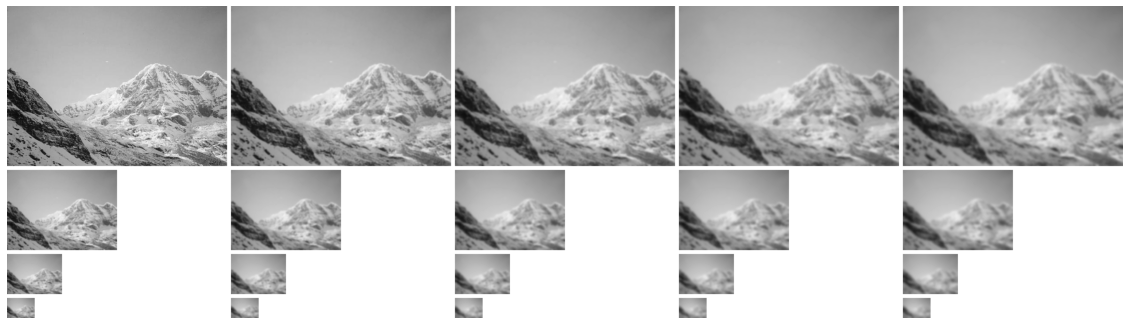

In [10]:
num_octave = 4
s = 2
sigma = 1

p = generate_gaussian_pyramid(image,num_octave,s,sigma)

output_pyr = plot_pyramid(p,image.shape)

fig = plt.figure(figsize=(20, 20))

plt.imshow(output_pyr,cmap=cm.gray)
plt.axis('off')
plt.show()

Lo scale space appena mostrato è in due dimensioni: 
- lungo le colonne, le immagini viene convolute iterativamente con un filtro gaussiano di devianza $k\sigma$. 
- Ogni riga inizia con la terz'ultima immagine della riga precedente, campionata al 50%.

E' interessante vedere le relazioni che esistono tra le varie immagini: poiché partiamo con $\sigma=1$, 


$$
\begin{array}{|c|c|c|c|}
    \hline
    \sigma = 1,s=1  & \sigma = \sqrt{2},s=1 & \sigma = 2,s=1 & \sigma = 2\sqrt{2},s=1& \sigma = 4,s=1\\
    \sigma = 2,s=1/4 & \sigma = 2\sqrt{2},s=1/4 & \sigma = 4,s=1/4 & \sigma = 4\sqrt{2},s=1/4& \sigma = 8,s=1/4\\
    \sigma = 4,s=1/16 & \sigma = 4\sqrt{2},s=1/16 & \sigma = 8,s=1/16 & \sigma = 8\sqrt{2},s=1/16& \sigma = 16,s=1/16\\
    \sigma = 8,s=1/32  & \sigma = 8\sqrt{2},s=1/32 & \sigma = 16,s=1/32 & \sigma = 16\sqrt{2},s=1/32& \sigma = 32,s=1/32\\
    \hline
\end{array}
$$

## Extrema detection

Data una sequenza di ottave, un'idea semplice per trovare gli estremi potrebbe essere quella di applicare il laplaciano "smoothed" (ovvero il laplaciano della gaussiana, LoG). La formula per LoG è data da

$$
\nabla^2 G_\sigma (x,y) = \left(\frac{x^2+y^2-2\sigma^2}{\sigma^4}\right)e^{-\frac{x^2+y^2}{2\sigma^2}}
$$

Se proviamo ad applicarlo all'immagine originale otteniamo quel che segue.

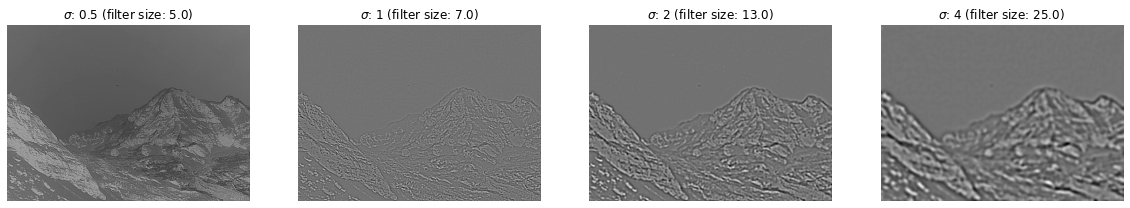

In [11]:
fig = plt.figure(figsize=(20, 20))

num_octave = 4

for i in range(num_octave):
    sigma = 2**(i-1)
    fig.add_subplot(1, num_octave, i+1) 
    plt.imshow(ndimage.gaussian_laplace(image,sigma),cmap=cm.gray)
    s = 2*np.ceil(3*sigma)+1
    plt.title(f'$\sigma$: {sigma} (filter size: {s})')
    plt.axis('off')

plt.show()

Applicare LoG alle immagini così costruite permetterebbe di individuare delle zone da "attenzionare" per l'individuazione dei keypoint. Il problema è che aumentando la scala (ovvero, la devianza $\sigma$), il responso del filtro tende a diluirsi. Per ovviare a questo problema è possibile pesare LoG con un fattore proporzionale alla scala: 

$$
\sigma^2\nabla^2G_\sigma
$$

Cerchiamo di capire questa cosa con un esempio

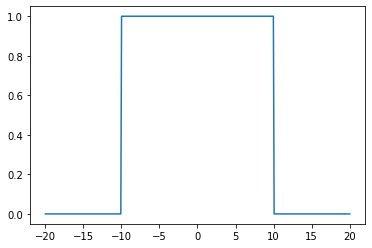

In [12]:
a = 100
b = 200

sig = np.concatenate((np.zeros(a),np.ones(b),np.zeros(a)))

x = np.linspace(-20,20,a*2 + b)


plt.plot(x,sig)

plt.show()

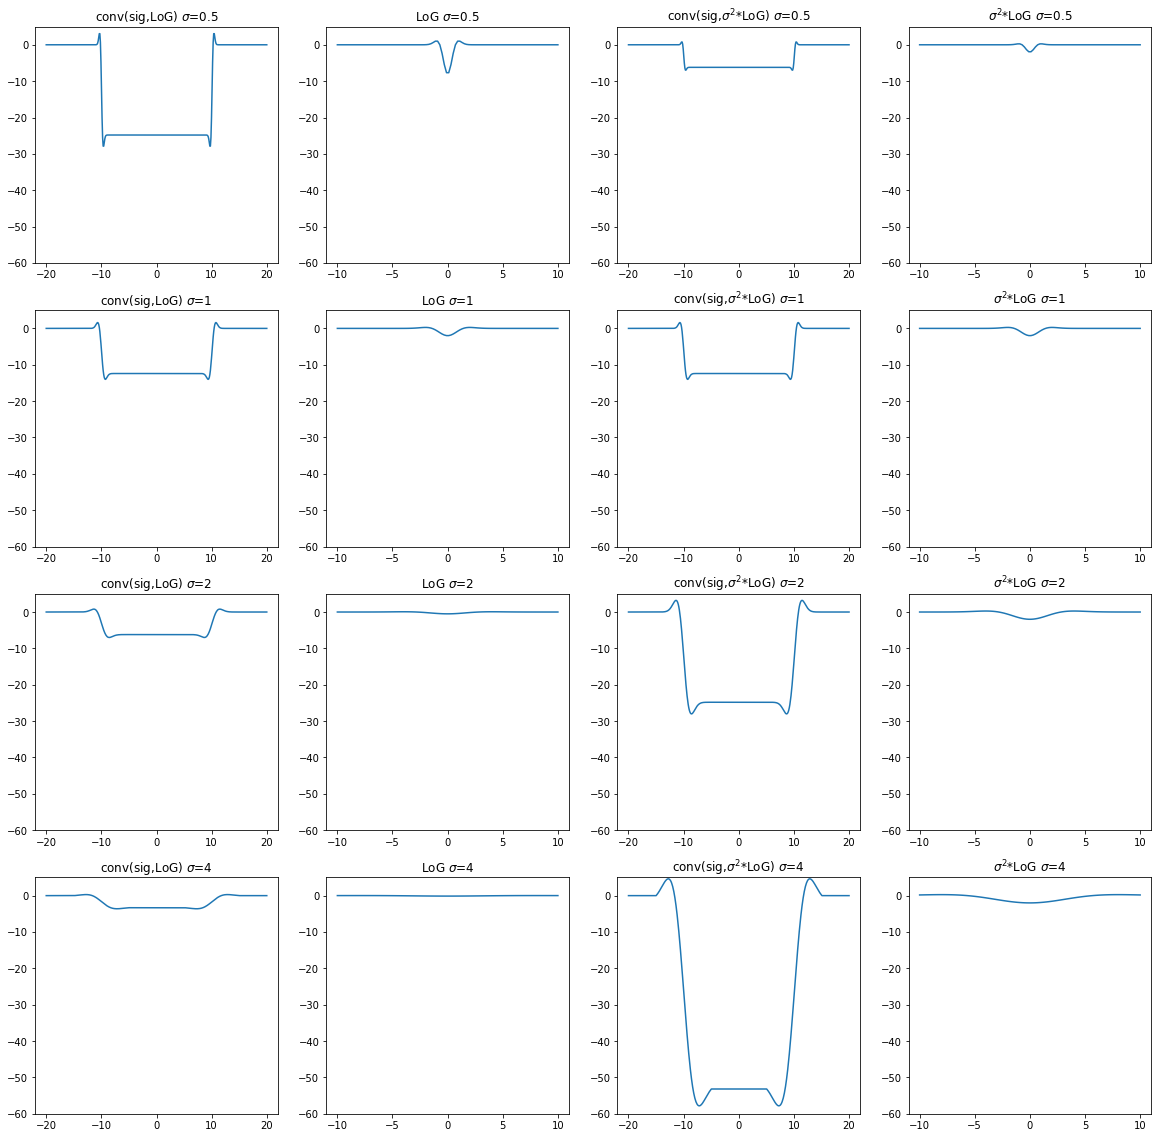

In [23]:
from scipy import signal

def LoG(x,sigma):
    return ((x**2 - 2*sigma**2)/(sigma**4))*np.exp(-x**2/(2*sigma**2))


fig = plt.figure(figsize=(20, 20))

k=1

y_min, y_max = -60, 5
scales = 4

for i in range(scales):
    sigma = 2**(i-1)

    w = np.linspace(-10,10,100)
    lg = LoG(w,sigma)

    y = signal.convolve(sig, lg, mode='same')
    z = signal.convolve(sig, (sigma**2)*lg, mode='same')

    
    fig.add_subplot(scales, 4, k) 
    plt.ylim([y_min, y_max])
    plt.plot(x,y)
    plt.title(f'conv(sig,LoG) $\sigma$={sigma}')
    
    fig.add_subplot(scales, 4, k+1)
    plt.ylim([y_min, y_max])
    plt.plot(w,lg)
    plt.title(f'LoG $\sigma$={sigma}')
    
    fig.add_subplot(scales, 4, k+2) 
    plt.ylim([y_min, y_max])
    plt.plot(x,z)
    plt.title(f'conv(sig,$\sigma^2$*LoG) $\sigma$={sigma}')
    
    fig.add_subplot(scales, 4, k+3)
    plt.ylim([y_min, y_max])
    plt.plot(w,(sigma**2)*lg)
    plt.title(f'$\sigma^2$*LoG $\sigma$={sigma}')

    k += 4
    

plt.show()

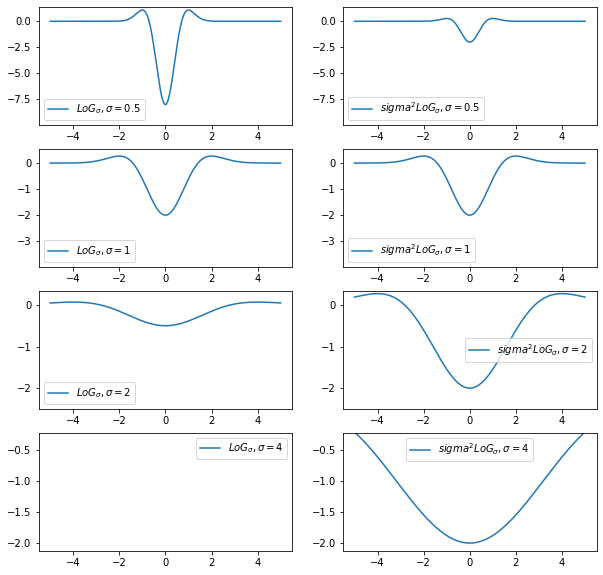

In [37]:
x = np.linspace(-5,5,1000)

fig = plt.figure(figsize=(10, 10))

k = 1
for i in range(num_octave):
    sigma = 2**(i-1)
    y = LoG(x,sigma) 
    #y2= y/sigma**2
    y2= y*sigma**2
    
    y_min, y_max = min(y+y2), max(y+y2)
    #y_min, y_max = None, None

    
    fig.add_subplot(num_octave, 2, k) 
    plt.plot(x,y,label=f'$LoG_\sigma, \sigma={sigma}$')
    plt.ylim([y_min, y_max])
    plt.legend()

    fig.add_subplot(num_octave, 2, k+1) 
    plt.plot(x,y2,label=f'$sigma^2LoG_\sigma, \sigma={sigma}$')
    plt.ylim([y_min, y_max])
    plt.legend()
    k += 2

plt.show()

Si noti come, nel grafico sopra, le scale vengono mantenute costanti. Applicato alle immagini, otteniamo:

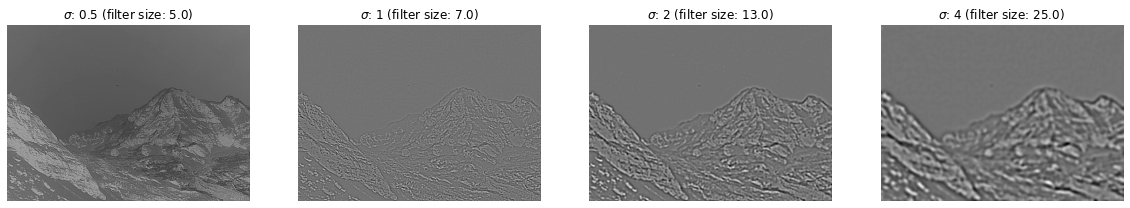

In [39]:
fig = plt.figure(figsize=(20, 20))

num_octave = 4

for i in range(num_octave):
    sigma = 2**(i-1)
    fig.add_subplot(1, num_octave, i+1) 
    plt.imshow(sigma**2*ndimage.gaussian_laplace(image,sigma),cmap=cm.gray)
    s = 2*np.ceil(3*sigma)+1
    plt.title(f'$\sigma$: {sigma} (filter size: {s})')
    plt.axis('off')

plt.show()

Un aspetto interessante è che l'applicazione del laplaciano può essere ottenuta direttamente, calcolando la differenza tra le immagini in una ottava. Infatti, si può dimostrare (lo faremo graficamente, ma è possibile anche farlo analiticamente) che 

$$G_{k\sigma}(x,y)-G_{\sigma}(x,y) \approx (k-1)\sigma^2\nabla^2G_\sigma(x,y)$$

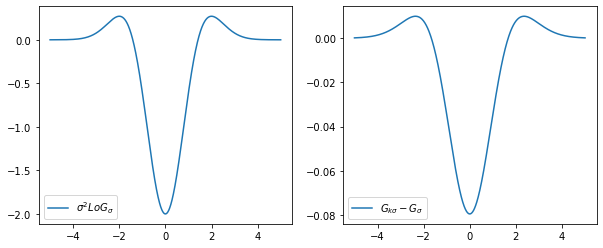

In [40]:
def G(x,sigma):
    return (1/(2*np.pi*sigma**2))*np.exp(-x**2/(2*sigma**2))

x = np.linspace(-5,5,1000)

sigma = 1
k = np.sqrt(2)

y = LoG(x,sigma)

z = (G(x,k*sigma) - G(x,sigma))

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(1, 2, 1) 
plt.plot(x,y,label='$\sigma^2LoG_\sigma$')
plt.legend()

fig.add_subplot(1, 2, 2) 
plt.plot(x,z,label='$G_{k\sigma} - G_{\sigma}$')
plt.legend()


plt.show()


A questo punto possiamo ottenere le ottave di DoG: 

In [41]:
def generate_DoG_octave(gaussian_octave,use_concat): 
    octave = [] 
    for i in range(1, len(gaussian_octave)):   
        octave.append(gaussian_octave[i] - gaussian_octave[i-1]) 
    if use_concat:
        return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2) 
    else:
        return octave

def generate_DoG_pyramid(gaussian_pyramid,use_concat=False): 
    pyr = [] 
    for gaussian_octave in gaussian_pyramid: 
        pyr.append(generate_DoG_octave(gaussian_octave,use_concat)) 
    return pyr

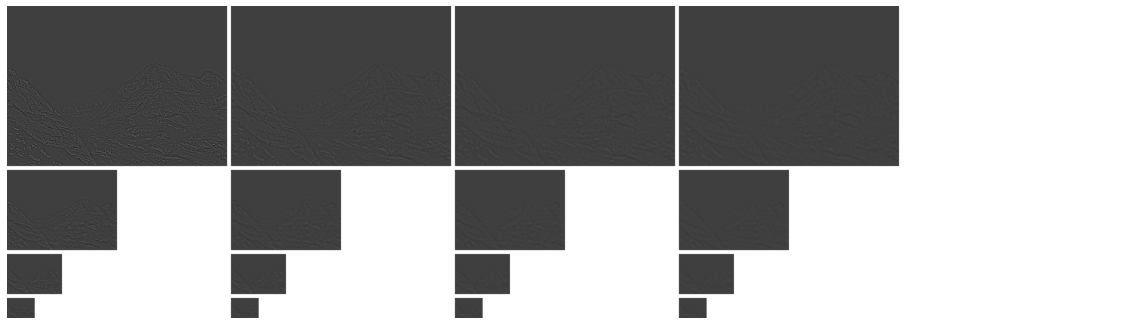

In [42]:
num_octave = 4
s = 2
sigma = 1

p = generate_gaussian_pyramid(image,num_octave,s,sigma)
d = generate_DoG_pyramid(p)

output_pyr = plot_pyramid(d,image.shape)

fig = plt.figure(figsize=(20, 20))

plt.imshow(output_pyr,cmap=cm.gray)
plt.axis('off')
plt.show()

A questo punto, avendo costruito la piramide con le varie scale, possiamo individuare i keypoints candidati.

![](candidate_keypoints.png)

Un keypoint si considera come candidato se è il centro di una graglia 3x3x3 e rappresenta il minimo o il massimo tra i vicini.

La ricerca avviene per ogni piramide e iterando sui diversi livelli

In [43]:
num_octave = 4
s = 2
sigma = 1

p = generate_gaussian_pyramid(image,num_octave,s,sigma)
d = generate_DoG_pyramid(p, True)

DoG_shapes = [x.shape for x in d]

DoG_shapes

[(415, 572, 4), (208, 286, 4), (104, 143, 4), (52, 72, 4)]

Ad esempio per la prima DoG quanti punti otteniamo?

Il metodo *get_candidate_keypoints* itera su tutti i punti dell'immagine scansionando con uno step di $\frac{w}{2}$ e costruisce delle patch 3x3x3.

Poiché in una patch 3x3x3 ci sono 27 elementi, considerando la matrice come un vettore monodimensionale, il centro è in posizione *27//2*

In [77]:
def get_candidate_keypoints(D, w=16): 
    candidates = [] 
    
    # add new levels for z iterations
    D[:,:,0] = 0 
    D[:,:,-1] = 0
    
    # iter on x
    for i in range(w//2+1, D.shape[0] - w//2-1): 
        # iter on y
        for j in range(w//2+1, D.shape[1]-w//2-1): 
            # iter on z
            for k in range(1, D.shape[2]-1): 
                patch = D[i-1:i+2, j-1:j+2, k-1:k+2] 
                if np.argmax(patch) == 13 or np.argmin(patch) == 13: 
                    candidates.append([i, j, k]) 
    return candidates

first_DoG = d[0]
candidates = get_candidate_keypoints(first_DoG)

candidates_array = np.array(candidates)

print(f'{candidates_array}\n Shape: {candidates_array.shape}')

[[  9  12   1]
 [  9  56   1]
 [  9  61   1]
 ...
 [405 494   1]
 [405 518   1]
 [405 533   1]]
 Shape: (7877, 3)


sono stati trovati moltissimi punti! Quindi è necessario un processo di selezione.

Come si vedono questi punti sull'ottava?

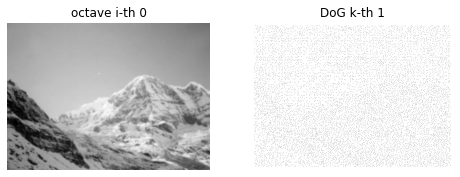

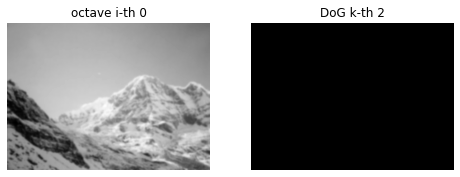

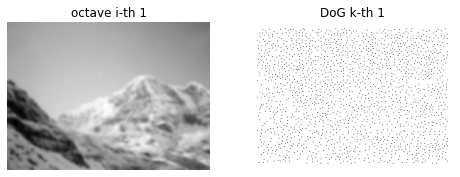

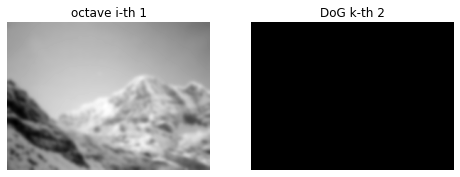

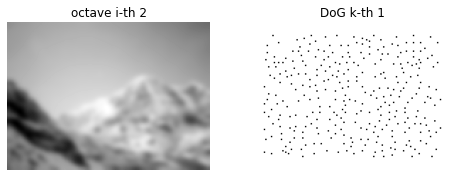

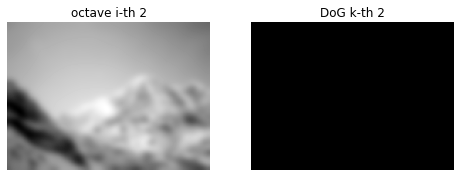

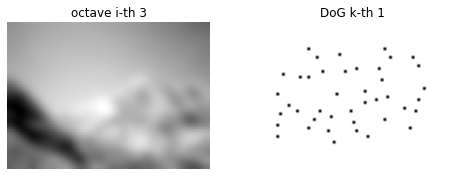

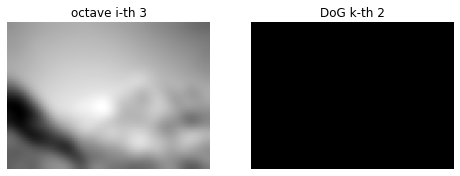

In [99]:
for i, computed_DoG in enumerate(d):
    candidates_i = get_candidate_keypoints(computed_DoG)
    
    for k in range(1, computed_DoG.shape[2]-1):
        points = [x for x in candidates_i if x[-1] == k]

        points_image = np.ones_like(p[i][k])
        
        for x, y, _ in points:
            points_image[x, y] = 0

        fig, ax = plt.subplots(1, 2, figsize=(8, 6))
        ax[0].imshow(p[i][k], cmap='gray')
        ax[0].axis('off')
        ax[0].set_title(f'octave i-th {i}')

        ax[1].imshow(points_image, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title(f'DoG k-th {k}')

plt.show()    

# Keypoint Localization

Il processo di selezione si compone di tre step:

1. per ogni keypoint candidato si calcola la posizione del subpixel
2. fissata una threshold, si scartano i keypoint con un valore del subpixel inferiore alla soglia
3. si eliminano i keypoint ai bordi (e agli angoli)


Perché si introduce il concetto di subpixel? Cosa sono i keypoint candidati che sono stati individuati? E dove sono stati individuati?

Ricordate che stiamo analizzando la piramide di DoG? Che è stata ottenuta con valori crescenti di $\sigma$?

Quindi si utilizza un processo di raffinamento per individuare la posizione migliore, cioé il pixel che meglio rappresenta la vera posizione di un keypoint.
E contemporaneamente si eliminano i punti con un basso valore di contrasto (la soglia!) e quelli che sono stati individuati ai bordi dell'immagine

## Subpixel Localization

Si utilizza un metodo che si basa sull'espansione di Taylor del secondo ordine per calcolare l'offset del subpixel rispetto al punto cadidato. Ovvero:

$$
z_0 = [x_0, y_0, \sigma]^T  \\
z = [\delta_x, \delta_y, \delta_\sigma]^T  \\
D(z_0 + z) \approx D(z_0) + ({\frac{\partial D}{\partial z}}|_{z_0})^T z + \frac {1}{2} z^T ({\frac{\partial^2 D}{\partial z^2}}|_{z_0}) z
$$


Derivando rispetto a *z* e eguagliando a 0, otteniamo

$$
\widehat{z} = - ({\frac{\partial^2 D}{\partial z^2}}|_{z_0}) ({\frac{\partial D}{\partial z}}|_{z_0})
$$

e $\widehat{z}$ è proprio l'offset che stiamo cercando.

Poiché consideriamo i punti vicini per calcolare le derivate, di fatto dobbiamo risolvere un sistema di equazioni 3x3.

Per risolvere questo sistema costruiamo il vettore Jacobiano con le derivate parziali prime e la matrice Hessiana con le derivate parziali seconde e ne facciamo il prodotto

$$
J = \begin{bmatrix}
D_x \\
D_y \\
D_s
\end{bmatrix}
$$

e

$$
H = \begin{bmatrix}
D_{xx} & D_{xy} & D_{xs} \\
D_{xy} & D_{yy} & D_{ys} \\
D_{xs} & D_{ys} & D_{ss} 
\end{bmatrix}
$$


In [20]:
def localize_keypoint(D, x, y, s):
	dx = (D[y,x+1,s]-D[y,x-1,s])/2.
	dy = (D[y+1,x,s]-D[y-1,x,s])/2.
	ds = (D[y,x,s+1]-D[y,x,s-1])/2.

	dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
	dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.
	dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.
	dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
	dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.
	dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]

	J = np.array([dx, dy, ds])
	HD = np.array([
		[dxx, dxy, dxs],
		[dxy, dyy, dys],
		[dxs, dys, dss]])
	
	offset = -LA.inv(HD).dot(J)	
	return offset, J, HD[:2,:2], x, y, s


first_kp = candidates[0]
print ('Keypoint', first_kp)

offset, J, HD, x, y, s = localize_keypoint(first_DoG, first_kp[0], first_kp[1], first_kp[2])

print('Offset', offset)
print('Jacobian', J)
print('Hessian\n', HD)

print('Keypoint Orig', x, y, s)

Keypoint [9, 12, 1]
Offset [-28.80642691  19.85536661   0.11174943]
Jacobian [ 6.42117581e-05  2.05709231e-04 -1.47988501e-04]
Hessian
 [[-3.29265108e-05 -5.11428044e-05]
 [-5.11428044e-05 -8.47979040e-05]]
Keypoint Orig 9 12 1


## Sub pixel inferiori ad una soglia

Il subpixel ottenuto sommando l'offset alle coordinate del punto candidato viene scartato se il valore di contrasto è inferiore ad una soglia. I punti con un contrasto basso non sono significativi per caratterizzare l'immagine, per questo motivo vengono scartati

Se $\widehat{x}$ è l'offset individuato ed *x* è il punto candidato, allora *x* viene scartato se la quantità seguente è inferiore alla soglia

$$
D(\widehat{x}) = D + \frac {1}{2} \frac {\partial D^T} {\partial x} \widehat{x}
$$

> Nel paper di SIFT viene utilizzato il valore 0.03

In [21]:
# esempio di valutazione del contrasto
t_c = .03

contrast = first_DoG[y,x,s] + .5*J.dot(offset) 
if abs(contrast) < t_c:
    print('point is discarded')

point is discarded


## Edge Subpixel

Eventuali keypoint ai bordi devono essere scartati a causa della difficoltà nel determinare l'orientamento del gradiente.
Come si possono riconoscere questi punti?

Si riutilizza una proprietà della matrice Hessiana **HD**:

*Se gli autovalori di HD sono molto grandi, allora il keypoint è un angolo. Se solo uno dei valori è molto grande, allora il punto è un bordo*

Quindi si riutilizza la matrice *HD* calcolata in precedenza (contenente le derivate di ordine 2)

Il rapporto tra gli autovalori equivale a valutare la curvatura di D e il rapporto

$$
\frac {(r+1)^2} {r}
$$

con *r* che rappresenta il rapporto degli autovalori, corrisponde al minimo quando gli autovalori sono uguale e poi cresce con *r*.

> Nel paper di SIFT viene utilizzato il valore 10 come valore limite 

In [22]:
R_th = (10+1)**2/10

w, v = LA.eig(HD)
r = w[1]/w[0]
R = (r+1)**2 / r

if R > R_th:
    print('point is discarded')

point is discarded


Quindi il pruning dei keypoint candidati avviene eseguendo i tre step descritti in precedenza.

In [23]:
def find_keypoints_for_DoG_octave(D, R_th, t_c, w):
    candidates = get_candidate_keypoints(D, w)
    
    keypoints = []

    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)
        
        # throw out low contrast points
        contrast = D[y,x,s] + .5 * J.dot(offset)
        if abs(contrast) < t_c:
            continue

        # # throw out edge points
        w, v = LA.eig(H)
        r = w[1]/w[0]
        R = (r+1)**2 / r
        if R > R_th: 
            continue

        # compute KP, but throw out boundary points
        kp = np.array([x, y, s]) + offset
        if kp[1] >= D.shape[0] or kp[0] >= D.shape[1]: 
            continue 

        keypoints.append(kp)

    print(f'#candidates = {len(candidates)}, #keypoints = {len(keypoints)}')
    
    return np.array(keypoints)


R_th = 10
t_c = .03
w_patch_size = 16
keypoints_first_DoG = find_keypoints_for_DoG_octave(first_DoG, R_th, t_c, w_patch_size)

print(f'{keypoints_first_DoG}\n Shape: {keypoints_first_DoG.shape}')

#candidates = 7877, #keypoints = 1486
[[408.75938434 154.24056872   1.2234741 ]
 [367.57668088 154.90026712   1.19036504]
 [424.83006557 158.92296556   1.1530998 ]
 ...
 [346.87703402 405.07882543   1.11209332]
 [367.77683613 404.8731439    1.14202255]
 [481.60012561 404.81703693   1.1847661 ]]
 Shape: (1486, 3)


In [67]:
# cambiando le soglie 
R_th_2 = 20
t_c_2 = .001
w_patch_size = 16
_ = find_keypoints_for_DoG_octave(first_DoG, R_th_2, t_c_2, w_patch_size)

#candidates = 7877, #keypoints = 5738


### Final step

A questo punto calcoliamo i keypoint per tutte le ottave

In [24]:
def get_keypoints(DoG_pyr, R_th, t_c, w):
    kps = []
    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))
    return kps

keypoints_pyr = get_keypoints(d, R_th, t_c, w_patch_size)

len(keypoints_pyr) == len(d)

#candidates = 7877, #keypoints = 1486
#candidates = 1695, #keypoints = 115
#candidates = 317, #keypoints = 22
#candidates = 42, #keypoints = 2


True

# Calcolo dell'orientamento

Fino a questo punto i keypoint calcolati non dipendono dalla scala e dalla posizione. L'altro aspetto da considerare è la rotazione.

La strategia è assegnare un orientamento ad ogni keypoint considerando la direzione del gradiente dominante considerando i suoi vicini.

1. Per ogni keypoint, si costruisce una patch di dimensione proporzionale alla scala.
2. Si calcola un istogramma dei gradienti per ogni pixel nella patch
    - si considera il valore pesato *Wg* dei gradienti e si assegna al bin corrispondente all'orientamento del gradiente
3. Si assegna l'orientamento pari al bin con valore massimo

Il numero di bin dell'istogramma è pari a 36, corrispondenti a step di 10° (360° // 36)

Ad ogni bin, per ogni gradiente, è aggiunto un valore *Wg* pari alla magnitudine del gradiente pesata dalla dimensione del filtro Gaussiano utilizzato per creare l'ottava

In questo modo l'orientamento del keypoint tiene in considerazione anche il livello di dettaglio dell'ottava ottentuto dall'applicazione del filtro gaussiano

In [28]:
def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()


def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta


def get_grad(L, x, y):
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    return cart_to_polar_grad(dx, dy)


def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)


def fit_parabola(hist, binno, bin_width):
    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.
    
    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])
    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)], 
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6
    return -x[1]/(2*x[0])


def assign_orientation(kps, octave, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        sigma = kp[2]*1.5
        w = int(2*np.ceil(sigma)+1)
        kernel = gaussian_filter(sigma)

        L = octave[...,s]
        hist = np.zeros(num_bins, dtype=np.float32)

        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = cx+ox, cy+oy
                
                if x < 0 or x > octave.shape[1]-1: 
                    continue
                elif y < 0 or y > octave.shape[0]-1: 
                    continue
                
                m, theta = get_grad(L, x, y)
                weight = kernel[oy+w, ox+w] * m

                bin = quantize_orientation(theta, num_bins)
                hist[bin] += weight

        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin: 
                continue

            if .8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

# compute orientations for first DoG
keypoints_with_orientation_firstDoG = assign_orientation(keypoints_pyr[0], first_DoG)

print(f'before {len(keypoints_pyr[0])} and {len(keypoints_with_orientation_firstDoG)} after orientation')

before 1486 and 2379 after orientation


**Osservazioni**

Per ogni istogramma, si considera l'orientamento del bin max. Ma si considerano anche i bin con valori superiori all'80% del max

Nel definire il valore di orientamento, si utilizza una funzione di interpolazione parabolare. Cioè per definire il valore esatto si utillizza la funzione di una parabola consideranto anche i valori vicini al max 



Calcoliamo l'orientamento per tutti i keypoint

In [29]:
keypoints_with_orientation = []

for i, DoG_octave in enumerate(d):
    kp_or = assign_orientation(keypoints_pyr[i], DoG_octave)
    
    keypoints_with_orientation.append(kp_or)
    
print('computed orientations for all octaves')    

computed orientations for all octaves


# Local descriptor creation

Lo step finale dell'algoritmo SIFT è il calcolo delle features finali (local descriptors).

Per ogni keypoint SIFT restituisce un vettore di 128 elementi. Come vengono calcolati?

Per ogni keypoint:

1. Si calcola una patch 16x16
2. La patch si suddivide in 16 regioni 4x4
3. Il gradiente (considerando le coordinate polari) per ogni regione è inserito in un istogramma con 8 bin
4. Gli istogrammi di tutte le regioni sono concatenati ottenendo un vettore di 4x4x8=128 elementi
5. Infine, il vettore finale è normalizzato, filtrato per una threshold e rinormalizzato. In questo modo il risultato finale è meno influenzato da piccoli cambiamenti sulla luminosità.


In [31]:
def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]

    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy

def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle-reference_angle) % 360
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        # binno*bin_width is the start angle of the histogram bin
        # binno*bin_width+bin_width/2 is the center of the histogram bin
        # angle - " is the distance from the angle to the center of the bin 
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    return hist

def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):
    descs = []
    bin_width = 360//num_bin

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)
        kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
        L = octave[...,s]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        patch = L[t:b, l:r]

        dx, dy = get_patch_grads(patch)

        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
            else: kernel = kernel[:dx.shape[0]]
        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:dx.shape[1]]

        if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
            else: kernel = kernel[:dy.shape[0]]
        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:dy.shape[1]]

        m, theta = cart_to_polar_grad(dx, dy)
        dx, dy = dx*kernel, dy*kernel

        subregion_w = w//num_subregion
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                                theta[t:b, l:r].ravel(), 
                                                num_bin, 
                                                kp[3], 
                                                bin_width,
                                                subregion_w)
                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        featvec /= max(1e-6, LA.norm(featvec))
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, LA.norm(featvec))
        descs.append(featvec)

    return np.array(descs)

Calcolo dei descrittori per tutti i keypoint individuati al passo precedente

In [32]:
feature_descriptors = []

for i, DoG_octave in enumerate(d):
    local_desc = get_local_descriptors(keypoints_with_orientation[i], DoG_octave)
    
    feature_descriptors.append(local_desc)
    
    
print('computed all local descriptors')    

computed all local descriptors


###### Link utili

- https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdfhttps://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf

- http://www.micc.unifi.it/delbimbo/wp-content/uploads/2011/10/slide_corso/A32_keypoint_detectors.pdfhttp://www.micc.unifi.it/delbimbo/wp-content/uploads/2011/10/slide_corso/A32_keypoint_detectors.pdf

- https://lerner98.medium.com/implementing-sift-in-python-36c619df7945

- https://towardsdatascience.com/sift-scale-invariant-feature-transform-c7233dc60f37